## Olfactory search with finite-state controllers

Description:
Optimization of the FSC model for the plume tracking task

----------------------------------------------------------------------------

Author: kyrellverano
LastUpdate: 2019-09-16

----------------------------------------------------------------------------

Reference: https://doi.org/10.1101/2023.03.10.532037

----------------------------------------------------------------------------

Contributors: 

    LuisAlfredoNu | <luis.alfredo.nu@gmail.com> | LastUpdate: 2023-08-25

----------------------------------------------------------------------------

In [37]:
import sys
import json
import os
import time

import numpy as np
import itertools as it
from scipy.special import softmax as softmax

import matplotlib.pyplot as plt

import importlib
sys.path.append('../Comm/')
import utils as utils
importlib.reload(utils)

# ----------------------------------------------------------------------------
# Select the library to solve the linear system 
# lib_solve_linear_system = 'scipy'
lib_solve_linear_system = 'petsc'
# lib_solve_linear_system = 'cupy'

solver = utils.solver_opt()
solver.set_lib_solver(lib_solve_linear_system)

# ----------------------------------------------------------------------------

# Set the precision for printing
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=1000)

# ----------------------------------------------------------------------------
# Fix the seed for reproducibility
np.random.seed(33+33)


Using petsc solver


## Set the conditions of the FSC model
### Default values

### Agent's parameters

In [38]:
M = 3                # Memory states [Available:1,2,3,4]
A = 4                # Action size 

# Set the action handler
act_hdl = utils.AgentActions(A)
act_hdl.set_action(0, [ 0,-1], 'left')
act_hdl.set_action(1, [ 0, 1], 'right')
act_hdl.set_action(2, [ 1, 0], 'up')
act_hdl.set_action(3, [-1, 0], 'down')

max_obs = 10       # Distinct observations for rewards
O = 2              # Distinct observations for actions [0, 1, 2, .., O-1]

lr_th = 0.01            # Learning rate
gamma = 0.99975      # Discount rate
gamma = 0.99      # Discount rate

cost_move = 1-gamma   # Cost for moving
reward_find = 0.0     # Reward for finding the goal


### Environment's parameters

In [39]:
# Dimension of grid: Lx by Ly
factor_dim = 0.6

Lx = int(92 * factor_dim)
Ly = int(131 * factor_dim)

# Location of source (Lx0,Ly0)
Lx0 = (Lx/2)-0.5
Ly0 = Ly * 0.70
Ly0 += 0.2
find_range = 2.1     #radius from source location to be considered as found target

#combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., uM0, uM1, ..., dM0, dM1, ...
a_size = A * M
L = Lx*Ly

# probability of track
beta = 1
sigma = 4

# ++++++++++++++++++
# CHANGE OF SCALES
scale = 1
L = int(L*scale)
sigma = sigma*scale
gamma = 1 - (1-gamma)/scale
beta = beta/scale

### Plume's parameters

In [40]:
# Inputs
coarse=0           # coarse = 1 ; non-coarse = 0
dth=5              # threshold for data [Available:5,12,15]

symmetry=1
replica=0          #if you wish to do multiple replicas

#Dimension of grid: Lx by Ly.. For coarse set-up, Lx should be an odd number.
if coarse==1 and (Lx % 2) == 0:
    sys.exit('Error in value for Lx. In COARSE set-up, Lx should be an odd number')

#if coarse == 1:    #change size and center for coarse set-up
#    Lx=91
#    Lx0=45


##Default parameters
V=100              #wind velocity for model plume

#DATA UPLOAD - used to compute P(y|s)
if symmetry == 0:
    data=np.loadtxt('data/exp_plume_threshold{}.dat'.format(dth))
if symmetry == 1:
    data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
if coarse == 1:
    data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))


### Program's parameters

In [41]:
#Maxtime in optimization
Ntot = 1000000
Ntot = 150
#Printing time interval
Nprint = 100
Nprint = 1

# Plot grids with the value of each variable
plot_maps = True
# Plot eta and Q on each iteration
plot_step = False

# Tolerance default
tol_eta = 0.00000001
tol_Q = 0.00000001
tol_conv = 0.0000000001    

In [42]:
# To use an input file, change input_file = True. The default inputs are from the previous cell.
input_file = False
input_filename = 'input.dat'

if input_file:    
    params = json.load(open(input_file))   ##change the file name
    coarse=params['coarse']   
    p_th=params['thresh']
    M = params["M"]                       # size of memory m = {0,1}
    A = params["A"]                       # action size
    act_move = params["actions_move"]     # action move
    act_name = params["actions_name"]     # action name


    O = params["O"]              # distinct observations for actions [0, 1, 2, .., O-1]
    max_obs = params["max_obs"]  # distinct observations for rewards

    symmetry=params['symmetry']
    replica = params["replica"]


    Lx = params["Lx"]
    Ly = params["Ly"]
    Lx0 = (Lx/2)-0.5
    Ly0 = params["Ly0"]

    if coarse==1 and (Lx % 2) == 0:
        sys.exit('Error in value for Lx. In COARSE set-up, Lx should be an odd number')

    # Tolerance override
    if ("tol_eta" in params.keys()):
        tol_eta = params["tol_eta"]
    if ("tol_Q" in params.keys()):
        tol_Q = params["tol_Q"]
    if ("lr_th" in params.keys()):
        lr_th = params["lr_th"]
    if ("tol_conv" in params.keys()):
        tol_conv = params["tol_conv"]

    find_range = params["find_range"]
    gamma = params["gamma"]
    V = 100
    if ("V" in params.keys()):
        V = params["V"]

    # combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., sM0, sM1, ...
    a_size = A * M
    L = Lx*Ly

    # cost move
    cost_move = 1-gamma
    if ("cost_move" in params.keys()):
        beta = params["cost_move"]
    reward_find = params["reward_find"]

    beta = 5
    if ("beta" in params.keys()):
        beta = params["beta"]

    #Maxtime in optimization
    Ntot = params["Ntot"]
    #Printing time interval
    Nprint = params["Nprint"]


    #data
    if symmetry == 0:
        data=np.loadtxt('data/exp_plume_threshold{}.dat'.format(dth))
    if symmetry == 1:
        data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
    if coarse == 1:
        data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))

    #++++++++
    #INITIALIZATIONS

    act_hdl = utils.AgentActions(A)
    for i,move,name in zip(range(A),act_move,act_name):
        act_hdl.set_action(i,move,name)

    eta = np.zeros(L*M)
    PObs_lim, RR, PObs,RR_np = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, 
                                        reward_find, M, beta, max_obs, O, A, V, data=data,source_as_zero=source_as_zero)
    PObs_lim = np.abs(PObs_lim)

    # Initial density is only at y=0, proportional to signal probability
    rho0 = np.zeros(M*Lx*Ly)
    #rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
    rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))


    if ("ev" in params.keys()):
        rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
    else:
        rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

    print('tol_conv:{}, tolQ:{}, toleta:{}'.format(tol_conv,tol_Q,tol_eta))   

### Create folder to save outputs

In [43]:
name_folder = 'outputs/ExpPlume_A{}M{}b{}g{}FR{}LR{}sym{}th{}rep{}LX{}LY{}co{}'.format(A,M,beta,gamma,find_range,lr_th,symmetry,dth,replica,Lx,Ly,coarse)
os.makedirs(name_folder, exist_ok=True)
#os.system("cp {} {}".format('./'+sys.argv[1], './'+name_folder))
f = open(name_folder+"/values.dat", "a")

In [44]:
print('Lx :{}, Ly :{}'.format(Lx, Ly))
print('Lx0:{}, Ly0:{}'.format(Lx0, Ly0))
print('M:{}, th:{}, replica:{}'.format(M, dth,replica))
print('tol_conv:{}, tolQ:{}, toleta:{}, learn_rate:{}'.format(tol_conv,tol_Q,tol_eta,lr_th))


#INITIALIZATIONS
yxs = it.product(np.arange(Ly), np.arange(Lx))
yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
source_as_zero = np.array([i for i in yx_founds])

eta = np.zeros(L*M)
PObs_lim, RR, PObs, RR_np = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, 
                                    reward_find, M, beta, max_obs, O, A, V, data=data,source_as_zero=source_as_zero,exp_plume=True)
PObs_lim = np.abs(PObs_lim)

# Initial density is only at y=0, proportional to signal probability
rho0 = np.zeros(M*Lx*Ly)
#rho0[:Lx*Ly0//2] = (1-PObs_lim[0,:Lx*Ly0//2])/np.sum((1-PObs_lim[0,:Lx*Ly0//2]))
rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

Lx :55, Ly :78
Lx0:27.0, Ly0:54.8
M:3, th:5, replica:0
tol_conv:1e-10, tolQ:1e-08, toleta:1e-08, learn_rate:0.01


In [45]:
def plot_rho(rho, Lx, Ly, M):
    rho_map = rho.reshape((Ly,Lx,M))
    print("rho0 shape:{},  rho_map shape:{}".format(rho0.shape, rho_map.shape))
    plt.figure(figsize=(12,12//M))
    for m in range(M):
        plt.subplot(1,M,m+1)
        plt.imshow(rho_map[:,:,m])
        plt.colorbar()
        plt.title("rho0, m={}".format(m))

    plt.show()

def plot_PObs_lim(PObs_lim, Lx, Ly, M):
    PObs_lim_map = PObs_lim.reshape((O,M,Ly,Lx))
    print("PObs_lim shape:{},  PObs_lim_map shape:{}".format(PObs_lim.shape, PObs_lim_map.shape))
    for o in range(O):
        plt.figure(figsize=(12,12//M))
        for m in range(M):
            plt.subplot(1,M,m+1)
            plt.title('PObs_lim, o:{}, m:{}'.format(o,m))
            plt.imshow(PObs_lim_map[o,m,:,:])
            plt.colorbar()
        plt.show()
        
def plot_reward(RR, Lx, Ly, M):
    print("RR shape:{}".format(RR.shape))

    plt.figure(figsize=(12,12//M))
    for m in range(M):
        plt.subplot(1,M,m+1)
        plt.title('RR, m:{}'.format(m))
        plt.imshow(RR[m,:,:])
        plt.colorbar()

    plt.show()

# print("RR shape: ", RR.shape)
# RR_map = RR.reshape((M,Ly,Lx,M,A))

# print("RR_np shape: ", RR_np.shape, np.array(RR_np.shape).prod()*A*M)

# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# plt.title('RR')
# plt.imshow(RR_np[0,:,:])
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.title('RR_map')
# plt.imshow(RR_map[0,:,:,0,0])
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.title('RR diff')
# plt.imshow(RR_map[0,:,:,0,0]-RR_np[0,:,:])
# plt.colorbar()

# plt.show()


## Plot the FSC model

Plotting maps
Lx: 55, Ly: 78, M: 3, A: 4, O: 2, max_obs: 10
Lx0: 27.0000, Ly0: 54.8000
rho0 shape:(12870,),  rho_map shape:(78, 55, 3)


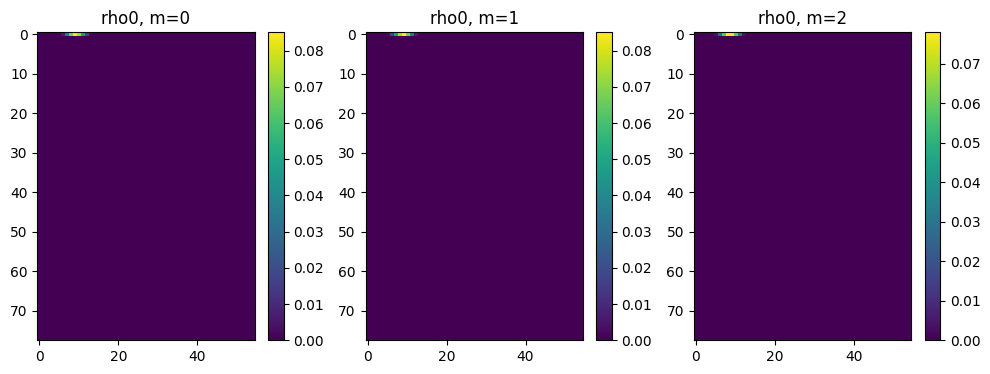

PObs_lim shape:(2, 12870),  PObs_lim_map shape:(2, 3, 78, 55)


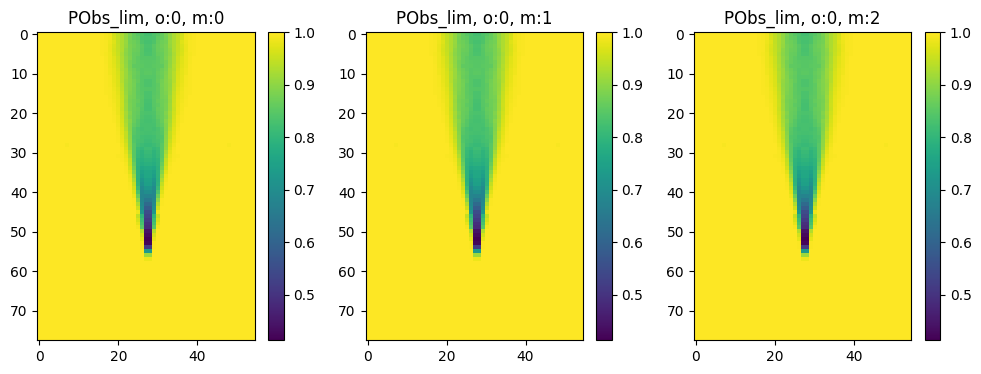

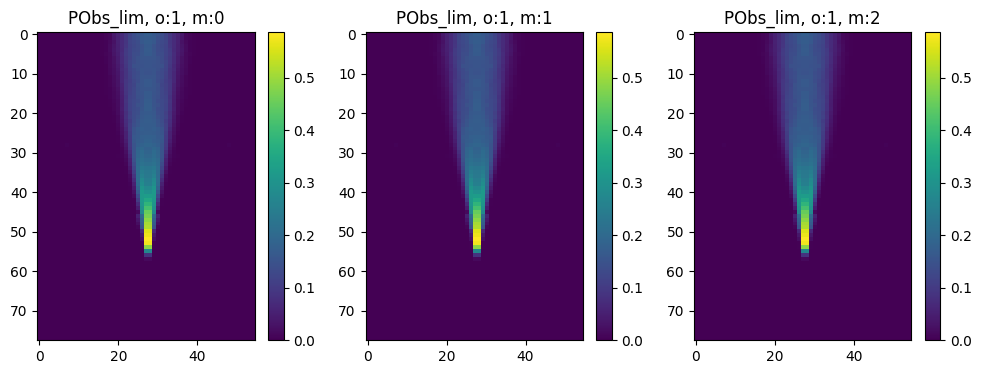

RR shape:(3, 78, 55)


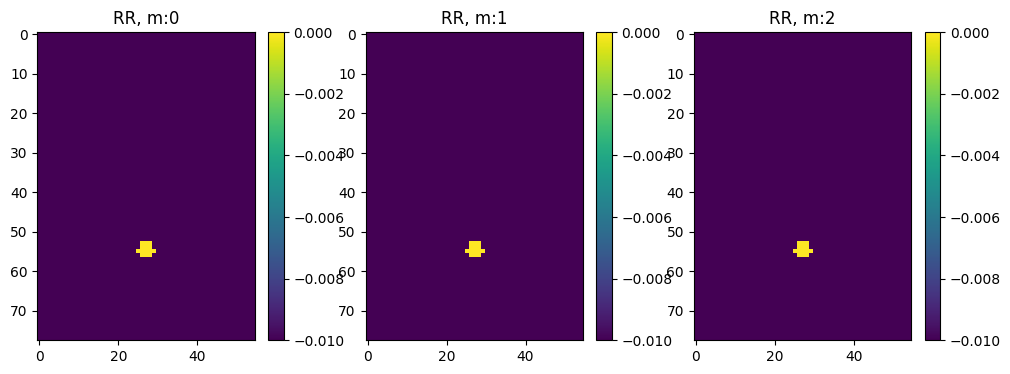

In [46]:
if plot_maps:
    print("Plotting maps")
    print("Lx: {}, Ly: {}, M: {}, A: {}, O: {}, max_obs: {}".format(Lx, Ly, M, A, O, max_obs))
    print("Lx0: {:.4f}, Ly0: {:.4f}".format(Lx0, Ly0))
    plot_rho(rho0, Lx, Ly, M)
    plot_PObs_lim(PObs_lim, Lx, Ly, M)
    plot_reward(RR_np, Lx, Ly, M)

In [47]:
# Policy Initialization with bias
restart = False
unbias = False    
if (restart):
    folder_restart = name_folder
    th = np.loadtxt(folder_restart + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(folder_restart + '/file_Q.out')
    eta = np.loadtxt(folder_restart + '/file_eta.out')
else:
    th = (np.random.rand(O, M, a_size)-0.5)*0.5 
    th[1:,:,2::A] += 0.5
    if (unbias):
        th[1:,:,2::A] -= 0.5
    eta = np.ones(eta.shape)/(L*M)/(1-gamma)
    eta = np.random.rand(M*Lx*Ly)
    Q = utils.create_random_Q0(Lx, Ly, Lx0, Ly0, gamma, a_size, M, cost_move, reward_find) 
       
# th = np.zeros((O, M, a_size)) #not 
pi = softmax(th, axis=2)

value = 0
oldvalue = value

value_lin = 0
oldvalue_lin = value_lin


In [48]:
# compute norms 
def norms_diff_mat(A,B):
    assert A.shape == B.shape
    print("2-norm: {:.5f}".format(np.linalg.norm(B-A, ord=2)),end=" ")
    print("1-norm: {:.5f}".format(np.linalg.norm(B-A, ord=1)),end=" ")
    print("inf-norm: {:.5f}".format(np.linalg.norm(B-A, ord=np.inf)))

def plot_eta_diff(eta_linSol,eta,M):
    print("Diff between eta fortran vs inverse")
    for im in range(M):
        fig = plt.figure(figsize=(16,4))
        plt.subplot(1,4,1)
        plt.title("Inverse")
        plt.imshow(eta_linSol[im])
        plt.colorbar()
        plt.subplot(1,4,2)
        plt.title("Iterative")
        plt.imshow(eta[im])
        plt.colorbar()
        plt.subplot(1,4,3)
        plt.title("Diff | M = {}".format(im))
        plt.imshow(np.abs(eta[im]-eta_linSol[im]))
        plt.colorbar()
        plt.subplot(1,4,4)
        plt.title("A / B ")
        plt.imshow((eta_linSol[im])/(eta[im]))
        plt.colorbar()

        norms_diff_mat(eta[im],eta_linSol[im])

        plt.show()

def plot_Q_diff(Q_linSol,Q,M,A):
    print("Diff between Q fortran vs inverse")
    for i in range(M):
        for j in range(A):
            print("Memory state: {}, Action: {}, Diff: {}".format(i,j,np.sum(np.abs(Q_linSol[0,:,:,i,j]-Q[0,:,:,i,j]))))
            print("    Inv min: {}, max: {}".format(np.min(Q_linSol[0,:,:,i,j]), np.max(Q_linSol[0,:,:,i,j])))
            print("Fortran min: {}, max: {}".format(np.min(Q[0,:,:,i,j]), np.max(Q[0,:,:,i,j])))
            fig = plt.figure(figsize=(16,4))
            plt.subplot(1,4,1)
            plt.title("Inverse M: {}, Action: {}".format(i,j))
            plt.imshow(Q_linSol[0,:,:,i,j])
            plt.colorbar()
            plt.subplot(1,4,2)
            plt.title("Fortran M: {}, Action: {}".format(i,j))
            plt.imshow(Q[0,:,:,i,j])
            plt.colorbar()
            plt.subplot(1,4,3)
            plt.title("Diff M: {}, Action: {}".format(i,j))
            plt.imshow(np.abs(Q_linSol[0,:,:,i,j]-Q[0,:,:,i,j]))
            plt.colorbar()
            plt.subplot(1,4,4)
            plt.title("A / B ")
            plt.imshow((Q_linSol[0,:,:,i,j])/(Q[0,:,:,i,j]))
            plt.colorbar()

            norms_diff_mat(Q[0,:,:,i,j],Q_linSol[0,:,:,i,j])
            plt.show()


In [49]:
#OPTIMIZATION ALGORITHM: NPG
#test print
# Nprint = 100
th_lin = th.copy()

print("Start optimization")
time_lin = 0.0
time_iter = 0.0

for t in range(Ntot):
    print("Iteration: {}".format(t))

    pi = softmax(th, axis=2)
    pi_lin = softmax(th_lin, axis=2)
    pi_diff_norms = [np.linalg.norm(pi_lin[i,:,:]-pi[i,:,:], ord=2) for i in range(O)]
    print("pi_diff_norms: ", pi_diff_norms)

    print("   Direct solver",end=' ')
    time_start = time.time()
    time_full = time.time()

    # Direct solution of linear system
    eta_linSol, T = utils.linear_solve_eta(pi_lin, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range, act_hdl,source_as_zero,solver=solver)
    print("eta time: {:.3f}".format(time.time()-time_start),end=' ')
    
    time_start = time.time()

    V, Q_linSol = utils.linear_solve_Q(T, Lx, Ly, M, A, gamma, find_range, act_hdl, source_as_zero,RR_np,solver=solver)
    print("Q time: {:.3f}".format(time.time()-time_start),end=' ')
    print("Total time: {:.3f}".format(time.time()-time_full))
    time_lin += time.time()-time_full

    print("Iterative solver",end=' ')
    time_start = time.time()
    time_full = time.time()
    # Iterative solutions of linear system
    eta = utils.iterative_solve_eta(pi, PObs_lim, gamma, rho0, eta, tol_eta, Lx, Ly, Lx0, Ly0, find_range)
    print("eta time: {:.3f}".format(time.time()-time_start),end=' ')
    time_start = time.time()

    Q = utils.iterative_solve_Q(pi, PObs_lim, gamma, RR, Q, tol_Q, Lx, Ly, Lx0, Ly0, find_range, cost_move)
    print("Q time: {:.3f}".format(time.time()-time_start),end=' ')
    print("Total time: {:.3f}".format(time.time()-time_full))
    time_iter += time.time()-time_full

    if (((t % Nprint == 1) or (Nprint == 1)) and plot_step):

        print("eta linSol shape", eta_linSol.shape)
        print("Q linSol shape", Q_linSol.shape)
        print("eta shape", eta.shape)
        print("Q shape", Q.shape)

        eta_linSol = eta_linSol.reshape(M,Ly,Lx)
        Q_linSol = Q_linSol.reshape(M,Ly,Lx,M,A)
        eta = eta.reshape(M,Ly,Lx)
        Q = Q.reshape(M,Ly,Lx,M,A)

        # Compare the direct solver and iterative solver for eta
        plot_eta_diff(eta_linSol,eta,M)

        # Compare the direct solver and iterative solver for Q
        plot_Q_diff(Q_linSol,Q,M,A)

        eta_linSol = eta_linSol.flatten()
        Q_linSol = Q_linSol.flatten()
        eta = eta.flatten()
        Q = Q.flatten()

    # Gradient calculation
    grad = utils.find_grad(pi, Q, eta, L, PObs_lim)
    grad -= np.max(grad, axis=2, keepdims=True)

    # Gradient calculation
    grad_lin = utils.find_grad(pi_lin, Q_linSol, eta_linSol, L, PObs_lim)
    grad_lin -= np.max(grad_lin, axis=2, keepdims=True)

    # Reset value for new iteration afterwards
    th += grad * lr_th / np.max(np.abs(grad)) # (t / Ntot + 0.5) #rescaled gradient
    th -= np.max(th, axis=2, keepdims=True)
    th = np.clip(th, -20, 0)

    # Reset value for new iteration afterwards
    th_lin += grad_lin * lr_th / np.max(np.abs(grad_lin)) # (t / Ntot + 0.5) #rescaled gradient
    th_lin -= np.max(th_lin, axis=2, keepdims=True)
    th_lin = np.clip(th_lin, -20, 0)

    # Print and check convergence
    if (t % Nprint == 0):
        pi_lin = softmax(th_lin, axis=2)
        value_lin =  utils.get_value(Q_linSol, pi_lin, PObs_lim, L, rho0)
        #print values in a file
        print('Dir current value: {} @ time:{} '.format(value_lin, t))

        # check convergence
        oldvalue_lin = value_lin

        pi = softmax(th, axis=2)
        value =  utils.get_value(Q, pi, PObs_lim, L, rho0)
        #print values in a file
        print('Ite current value: {} @ time:{} \n'.format(value, t))
        f.write('current value: {} @ time:{} \n'.format(value, t))
        f.flush()

        # check convergence
        if (abs((value-oldvalue)/value)<tol_conv):
            f.write('converged at T={}'.format(t))
            break
        oldvalue = value



    #if (t % (Nprint*10) == 0): #save every Nprint*10 in different files
    #    np.savetxt(name_folder + '/file_theta{}.out'.format(t), th.reshape(-1))
    #    np.savetxt(name_folder + '/file_Q{}.out'.format(t), Q.reshape(-1))
    #    np.savetxt(name_folder + '/file_eta{}.out'.format(t), eta.reshape(-1))
    if (t % (Nprint*10) == 0)   :#save every Nprint*10 overwriting previous files
        np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
        np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
        np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

# final print of converged policy (or if not converged, until Ntot)
np.savetxt(name_folder + '/file_theta.out', th.reshape(-1))
np.savetxt(name_folder + '/file_Q.out', Q.reshape(-1))
np.savetxt(name_folder + '/file_eta.out', eta.reshape(-1))

if t<Ntot:
    print('Direct solver converged at T={} with value={} on time {}'.format(t,value_lin,time_lin))
else:
    print('did not converged for {} runs and tolerance {}'.format(Ntot,))
    print('current value: {} @ time:{} \n'.format(value, t))

if t<Ntot:
    print('Iterative solver converged at T={} with value={} on time {}'.format(t,value,time_iter))
else:
    print('did not converged for {} runs and tolerance {}'.format(Ntot,))
    print('current value: {} @ time:{} \n'.format(value_lin, t))

Start optimization
Iteration: 0
pi_diff_norms:  [0.0, 0.0]
   Direct solver eta time: 2.904 Q time: 1.039 Total time: 3.947
Iterative solver eta time: 1.557 Q time: 10.552 Total time: 12.109
Dir current value: -0.9999916374679922 @ time:0 
Ite current value: -0.9999902481551585 @ time:0 

Iteration: 1
pi_diff_norms:  [3.0879634018247646e-05, 3.5216477528366435e-05]
   Direct solver eta time: 2.150 Q time: 1.270 Total time: 3.421
Iterative solver eta time: 0.408 Q time: 5.157 Total time: 5.565
Dir current value: -0.9999896010943011 @ time:1 
Ite current value: -0.9999905384609442 @ time:1 

Iteration: 2
pi_diff_norms:  [3.366865090207258e-05, 3.862231023424129e-05]
   Direct solver eta time: 2.074 Q time: 1.341 Total time: 3.418
Iterative solver eta time: 0.391 Q time: 5.425 Total time: 5.816
Dir current value: -0.9999871193291648 @ time:2 
Ite current value: -0.9999884254917474 @ time:2 

Iteration: 3
pi_diff_norms:  [3.2418073708401274e-05, 3.806459733231801e-05]
   Direct solver eta 

In [50]:
#POLICY ILLUSTRATION

def plot_policy(pi,M,O,act_hdl,obs_status,round_size=3):

    # Create labels
    actions = ["m{:d}-{}".format(i+1,act_hdl.action_name(j)) for i in range(M) for j in range(act_hdl.A)]
    memory = ["Mem{:d}".format(i+1) for i in range(M)]

    # List of styles for each observation
    styles = ['spring','summer','autumn','winter','cool','hot','bone','copper','pink','gray','flag','prism','ocean']

    cmap_style = ['viridis', 'plasma', 'cividis']
    cmap_style = ['Purples_r', 'Blues_r', 'Greens_r', 'Oranges_r']
    
    # Loop over observations
    for o in range(O):
        pn = pi[o].reshape(M,M*act_hdl.A)
        
        # Create the plot
        fig, ax = plt.subplots()
        im = ax.imshow(pn,cmap = cmap_style[o])
        # Rotate the tick labels and set their alignment.

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(len(actions)), labels=actions)
        ax.set_yticks(np.arange(len(memory)), labels=memory)

        pnn=np.round(pn,round_size)
        for i in range(len(memory)):
            for j in range(len(actions)):
                ax.text(j, i, pnn[i, j], ha="center", va="center", color="black")

        plt.title('policy p(m*,a|m,y={}) when {}'.format(o,obs_status[o]))
        plt.ylabel('initial memory(m)',fontsize=10)
        plt.xlabel('memory update and action(m*,a)',fontsize=10)
        fig.set_size_inches(10, 6)

        plt.show()


Plotting policy for iterative


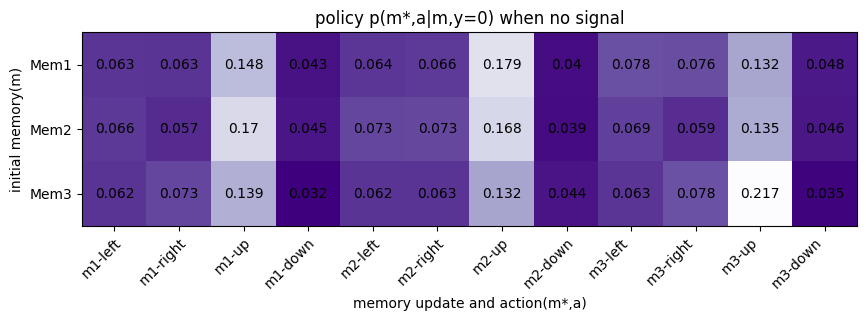

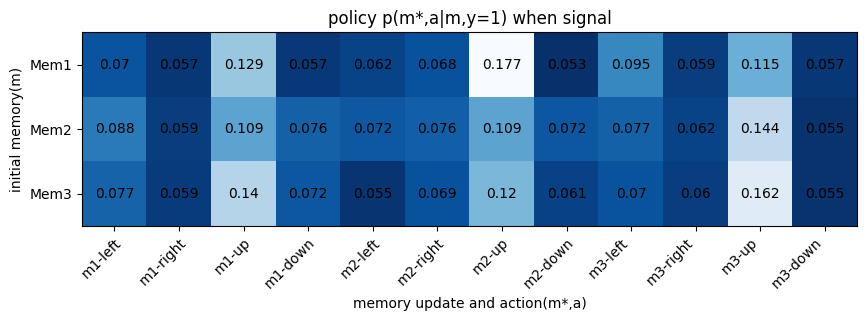

Plotting policy for direct


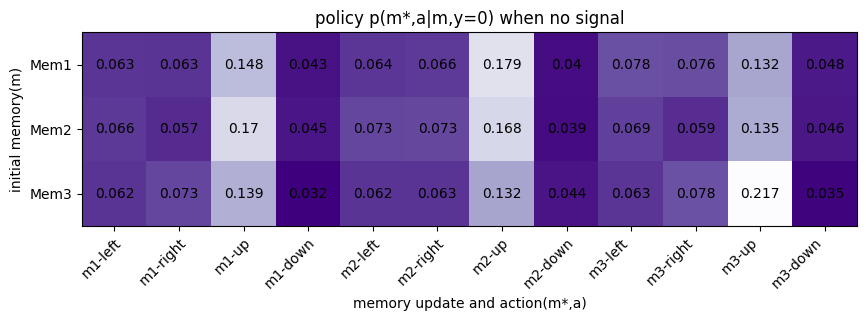

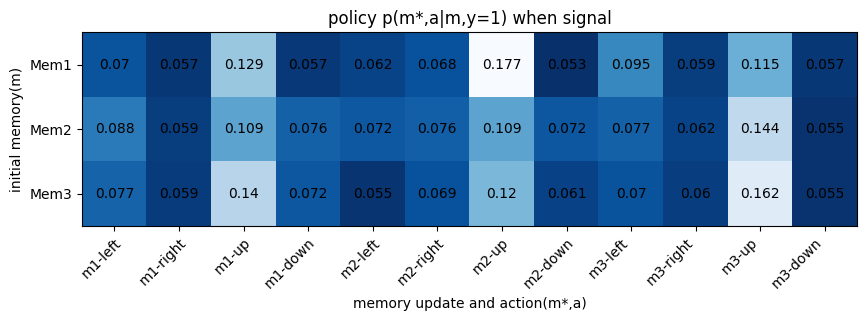

In [51]:

# Plot the policy
th_it = th
th_lin = th_lin

pi_lin = softmax(th_lin, axis=2)
pi_it = softmax(th_it, axis=2)

obs_status = ['no signal','signal','differs from signal']
for pi, pi_name in zip([pi_it, pi_lin],['iterative','direct']):
    print("Plotting policy for {}".format(pi_name))
    plot_policy(pi,M,O,act_hdl,obs_status)


pi_lin shape:  (2, 3, 12)
pi shape:  (2, 3, 12)
pi_diff_norms:  [2.175255508903864e-05, 3.8390318488432015e-05]
[[[ 0.       0.      -0.      -0.       0.       0.      -0.00001 -0.       0.       0.      -0.      -0.     ]
  [ 0.       0.      -0.00001 -0.       0.       0.      -0.00001 -0.       0.       0.      -0.00001 -0.     ]
  [ 0.       0.      -0.      -0.       0.       0.      -0.      -0.       0.       0.      -0.00001 -0.     ]]

 [[-0.      -0.00001  0.00001 -0.      -0.      -0.00001  0.00001 -0.       0.      -0.00001  0.00001 -0.     ]
  [ 0.      -0.00001  0.00001 -0.00001  0.      -0.00001  0.00001 -0.00001  0.      -0.00001  0.00001 -0.     ]
  [ 0.      -0.00001  0.00001 -0.00001 -0.      -0.00001  0.00001 -0.00001  0.      -0.00001  0.00001 -0.     ]]]


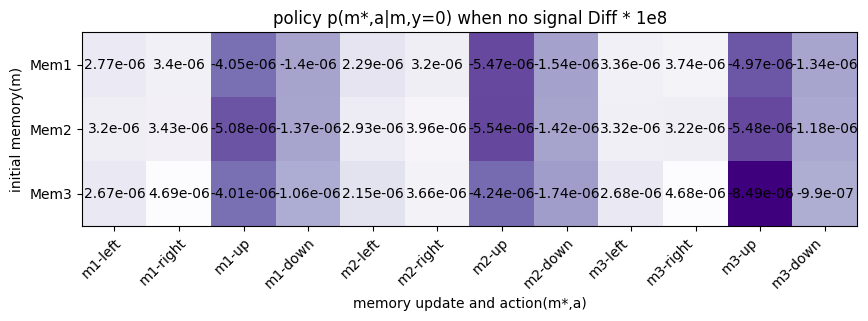

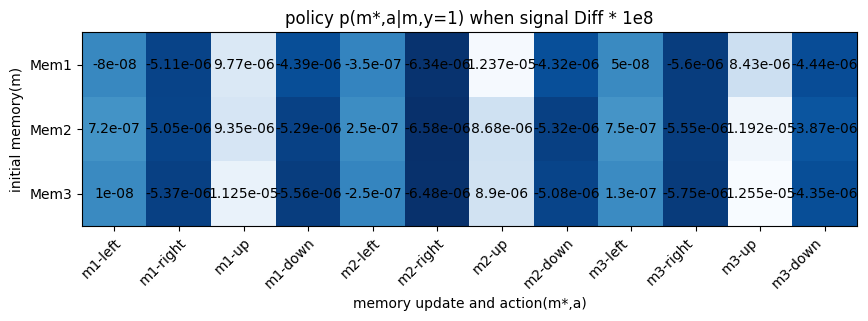

In [52]:
# Measure the difference between the two policies
print("pi_lin shape: ", pi_lin.shape)
print("pi shape: ", pi_it.shape)

pi_diff_norms = [np.linalg.norm(pi_lin[i,:,:]-pi_it[i,:,:], ord=2) for i in range(O)]

print("pi_diff_norms: ", pi_diff_norms)

# Plot the difference between the two policies
pi_diff = (pi_lin - pi_it) 
obs_status = [ x + ' Diff * 1e8' for x in ['no signal','signal','differs from signal']]
print(pi_diff)
plot_policy(pi_diff, M, O, act_hdl,obs_status,round_size=8)

Plotting trajectory for direct


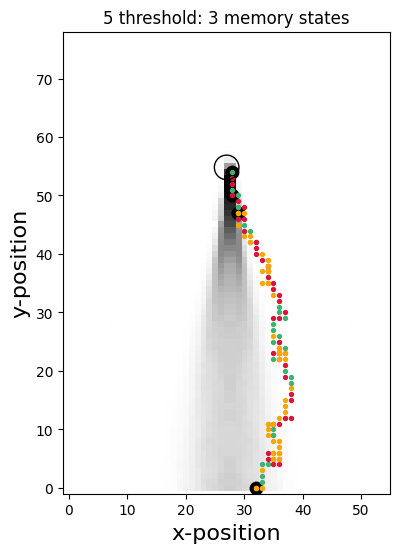

Plotting trajectory for iterative


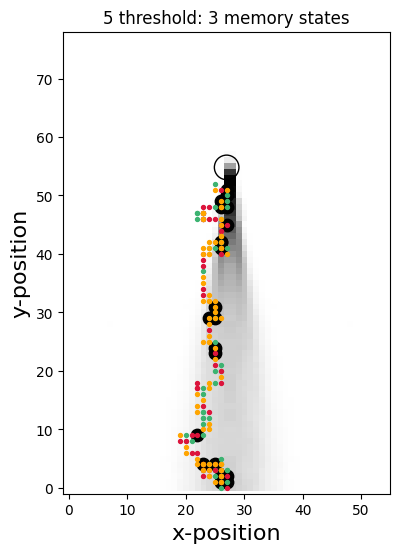

In [58]:
# Visualize after optimization
# Sample Trajectory

for th, title in zip([th_lin, th_it],['direct','iterative']):
    print("Plotting trajectory for {}".format(title))
    trj, ret, _ = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, gamma, PObs_lim, rho0, act_hdl)
    scatter_x = trj[1:,1]
    scatter_y = trj[1:,2]
    group = trj[1:,3]
    cdict = {2: 'orange', 0: 'mediumseagreen', 1: 'crimson', 3:'blue'}
    
    fig, ax = plt.subplots()
    
    ix = np.where(trj[1:,4] > 0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = 'black', s = 80)
    ix = np.where(group == 0.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[0], label = 'Memory 0', s = 8)
    ix = np.where(group == 1.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[1], label = 'Memory 1', s = 8)
    ix = np.where(group == 2.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[2], label = 'Memory 2', s = 8)
    ix = np.where(group == 3.0)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[3], label = 'Memory 3', s = 8)
    #ax.legend()
    ax.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:],cmap='Greys')
    fig.set_size_inches(10, 6)
    crange=plt.Circle((Lx0,Ly0),find_range,fill=False)
    ax.set_aspect(1)
    
    ax.add_artist(crange)
    plt.title('{} threshold: {} memory states'.format(dth, M))
    plt.xlim((-1,Lx))
    plt.ylim((-1,Ly))
    plt.xlabel('x-position',fontsize=16)
    plt.ylabel('y-position',fontsize=16)
    plt.show()

In [59]:
#TIME DISTRIBUTIONS of search time 
#timedistributions

Nep = 1000    #number of trajectories to reproduce
Nep = 10   #number of trajectories to reproduce
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"
for th in [th_it,th_lin]:
    av_ret = 0.
    T = []
    print('Progress:',end=' ')
    for i in range(Nep):
        _, ret, tau = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, maxT, PObs_lim, rho0, act_hdl)
        av_ret += ret
        T.append(tau)
        if (i % (Nep // 10) == 0):
            print('=',end=' ')
    print(' ')
    print('Success Rate: {:.3f}%'.format(100*av_ret / Nep))


Progress: = = = = = = = = = =  
Success Rate: 30.000%
Progress: = = = = = = = = = =  
Success Rate: 40.000%
